## 1:1 문의 내용 유형 분류기

In [1]:
# 필요 라이브러리 설치
!pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.9/580.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.9/493.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 19.2 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e6f0f629f5062574398e6548d1bad27d539309e2e05f085de6aeeb9e8137ace2
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
!pip install konlpy
!pip install mecab-python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 10.9 MB/s eta 0:00:00


In [3]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from collections import Counter
import wget, os

In [4]:
# 자바 경로 설정(WIndows)
os.environ['JAVA_HOME'] = "C:\Program Files\Java\jdk-19"

In [5]:
# 한글 글꼴 설정(Colab)
!sudo apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,675 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124574 files and dire

In [6]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
fm.fontManager.addfont(FONT_PATH)
print(font_name)

plt.rcParams['font.family']=font_name
# plt.rcParams['axes.unicode_minus'] == False
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


In [7]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 데이터 불러오기

In [8]:
# 데이터 로딩
data = pd.read_csv('/content/drive/MyDrive/Type_of_Inquiry_Classification/train.csv')
data.shape

(3706, 2)

In [9]:
# 데이터 확인
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


In [10]:
# 데이터 확인
data.isnull().sum()

,0
text,0
label,0


- 데이터 탐색
    - 문의 내용 길이 분포

In [11]:
text_lengths = [len(data) for text in data]

In [12]:
data['length'] = data['text'].apply(len)

In [13]:
length = list(data['text'].apply(len))

In [14]:
# 문의 내용 최대 길이
maxlen = max(length)
length.index(maxlen)

2561

In [15]:
# 문의 내용 최소 길이
minlen = min(length)
length.index(minlen)

756

In [16]:
code1 = data.loc[data['label'] == '코드1']
code2 = data.loc[data['label'] == '코드2']
web = data.loc[data['label'] == '웹']
remote = data.loc[data['label'] == '원격']
theory = data.loc[data['label'] == '이론']
system = data.loc[data['label'] == '시스템 운영']

In [17]:
# code1 = data.loc[data['label'] == '코드1']

In [18]:
print(max(code1['text'].apply(len)))
print(min(code1['text'].apply(len)))

2655
12


In [19]:
print(max(code2['text'].apply(len)))
print(min(code2['text'].apply(len)))

6012
13


In [20]:
print(max(web['text'].apply(len)))
print(min(web['text'].apply(len)))

5690
13


In [21]:
print(max(remote['text'].apply(len)))
print(min(remote['text'].apply(len)))

683
9


- 데이터 탐색
    - 명사 추출하고 품사 태깅

In [22]:
from mecab import MeCab

mecab = MeCab()

In [23]:
data['nouns'] = data['text'].apply(mecab.nouns)

In [24]:
data.head()

,text,label,length,nouns
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]"
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[이미지, 개, 업로드, 자바, 스크립트, 동적, 폼, 개, 생성, 데, 클릭, 뭘..."
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[사용, 때, 질문, 포함, 작동, 것, 질문, 제공, 파일, 폴더, 포함, 폴더,..."
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[오류, 해결]"
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 안, 이미지, 저장, 걸로, 이해, 실행, 폴더, 이미지, 저장, 질문]"


In [25]:
# %%time
data['pos'] = data['text'].apply(mecab.pos)

In [26]:
data['morphs'] = data['text'].apply(mecab.morphs)

In [27]:
data.head()

,text,label,length,nouns,pos,morphs
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[(self, SL), (., SY), (convs, SL), (1, SN), (=...","[self, ., convs, 1, =, nn, ., ModuleList, (, [..."
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[이미지, 개, 업로드, 자바, 스크립트, 동적, 폼, 개, 생성, 데, 클릭, 뭘...","[(현재, MAG), (이미지, NNG), (를, JKO), (여러, MM), (개...","[현재, 이미지, 를, 여러, 개, 업로드, 하, 기, 위해, 자바, 스크립트, 로..."
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[사용, 때, 질문, 포함, 작동, 것, 질문, 제공, 파일, 폴더, 포함, 폴더,...","[(glob, SL), (., SY), (glob, SL), ((, SSO), (P...","[glob, ., glob, (, PATH, ), 를, 사용, 할, 때, 질문, 입..."
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[오류, 해결]","[(tmpp, SL), (=, SY), (tmp, SL), (., SY), (gro...","[tmpp, =, tmp, ., groupby, (, by, =, ', Addr, ..."
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 안, 이미지, 저장, 걸로, 이해, 실행, 폴더, 이미지, 저장, 질문]","[(filename, SL), (=, SY), (TEST, SL), (_, SY),...","[filename, =, TEST, _, IMAGE, +, str, (, round..."


In [28]:
%%time
from konlpy.tag import Okt

okt = Okt()

CPU times: user 1.68 s, sys: 166 ms, total: 1.85 s
Wall time: 2.28 s


In [29]:
%%time

data['text'].apply(okt.nouns)

CPU times: user 49.5 s, sys: 679 ms, total: 50.2 s
Wall time: 40.5 s


,text
0,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 이, 가정, 그냥, 선언, 것]"
1,"[현재, 이미지, 개, 업로드, 위해, 자바스크립트, 적, 폼, 개, 생, 클릭, ..."
2,"[를, 사용, 때, 질문, 포함, 제대로, 작동, 것, 질문, 제공, 파일, 폴더,..."
3,"[오류, 해결]"
4,"[안, 폴더, 안, 이미지, 저장, 는걸, 이해, 실행, 폴더, 이미지, 저장, 질문]"
...,...
3701,"[토큰, 이후, 를, 분리, 각, 벡터, 진행, 데이터, 나누기, 전, 한번, 벡터..."
3702,"[값, 중, 최고점, 건가, 최근, 파일, 무조건, 갱신, 최고점, 값, 경우, 변..."
3703,"[수업, 를, 이유, 인프라, 구조, 대해, 이해, 시간, 비록, 직접, 인프라, ..."
3704,"[해도, 값, 변경, 혹시, 원격지원, 계속]"


In [30]:
%%time

data['text'].apply(okt.pos)

CPU times: user 28.3 s, sys: 162 ms, total: 28.5 s
Wall time: 28 s


,text
0,"[(self, Alpha), (., Punctuation), (convs, Alph..."
1,"[(현재, Noun), (이미지, Noun), (를, Josa), (여러, Modi..."
2,"[(glob, Alpha), (., Punctuation), (glob, Alpha..."
3,"[(tmpp, Alpha), (=, Punctuation), (tmp, Alpha)..."
4,"[(filename, Alpha), (=, Punctuation), (TEST, A..."
...,...
3701,"[(토큰, Noun), (화, Suffix), (이후, Noun), (train, ..."
3702,"[(올린, Verb), (값, Noun), (들, Suffix), (중, Noun)..."
3703,"[(수업, Noun), (에서, Josa), (cacoo, Alpha), (랑, J..."
3704,"[(inplace, Alpha), (=, Punctuation), (True, Al..."


In [31]:
# Number of Samples / Number of words per sample 구해보기
print(sum(data['morphs'].apply(len)) / 3706)
print(3706 / (sum(data['morphs'].apply(len)) / 3706))

80.27415002698326
46.16679215855003


- 데이터 탐색
    - nltk로 텍스트 분석하기

In [32]:
import nltk
from nltk import sent_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
nouns = data.text.apply(lambda t: mecab.nouns(str(t)))
nouns = nouns.explode()
morphs = data.text.apply(lambda t: mecab.morphs(str(t)))
morphs = morphs.explode()
pos = data.text.apply(lambda t: mecab.pos(str(t)))
pos = pos.explode()

In [34]:
pos

,text
0,"(self, SL)"
0,"(., SY)"
0,"(convs, SL)"
0,"(1, SN)"
0,"(=, SY)"
...,...
3705,"(을, JKO)"
3705,"(해야, VV+EC)"
3705,"(하, VX)"
3705,"(나요, EF)"


In [35]:
nltk_nouns = nltk.Text(nouns)
nltk_nouns = nltk.Text([w for w in nouns if isinstance(w, str)])
nltk_morphs = nltk.Text(morphs)
nltk_morphs = nltk.Text([w for w in morphs if isinstance(w, str)])
nltk_pos = nltk.Text(pos)
# nltk_pos = nltk.Text([w for w in pos if isinstance(w, str)])

In [36]:
display(nltk_nouns.vocab())
print(len(nltk_nouns.vocab()))

FreqDist({'것': 1093, '수': 986, '값': 801, '데이터': 783, '문제': 725, '때': 714, '코드': 712, '실습': 609, '번': 596, '파일': 581, ...})

3423


In [37]:
display(nltk_morphs.vocab())
print(len(nltk_morphs.vocab()))

FreqDist({'.': 10783, '(': 6452, ',': 6362, '-': 5845, ')': 5668, '_': 5425, '하': 5410, '는': 4475, '이': 4155, '=': 4081, ...})

11066


In [38]:
display(nltk_pos.vocab())
print(len(nltk_pos.vocab()))

FreqDist({('(', 'SSO'): 6450, (',', 'SC'): 6342, ('-', 'SY'): 5845, ('.', 'SF'): 5557, (')', 'SSC'): 5517, ('_', 'SY'): 5425, ('.', 'SY'): 5226, ('=', 'SY'): 4081, ('하', 'XSV'): 3605, ('가', 'JKS'): 3373, ...})

11980


In [39]:
# 각각 token 갯수 / 전체 token 비율(Type-Token Ratio) 알아보기

print(len(set(nltk_nouns)) / len(nltk_nouns))
print(len(set(nltk_morphs)) / len(nltk_morphs))
print(len(set(nltk_pos)) / len(nltk_pos))

0.060026304252520826
0.03719713878505929
0.040269449000994974


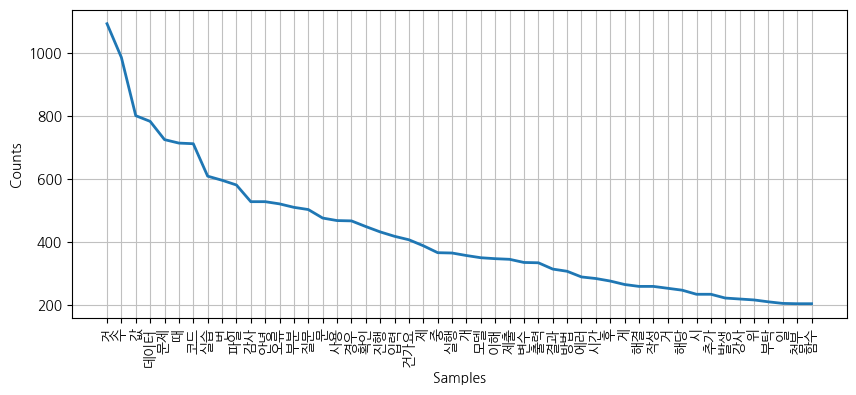

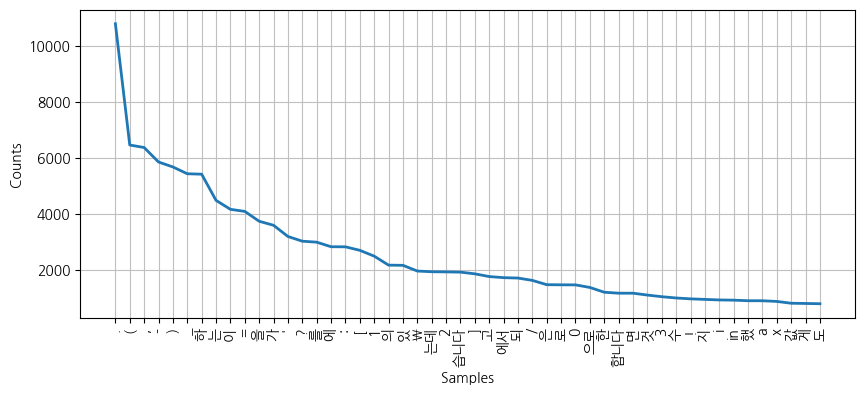

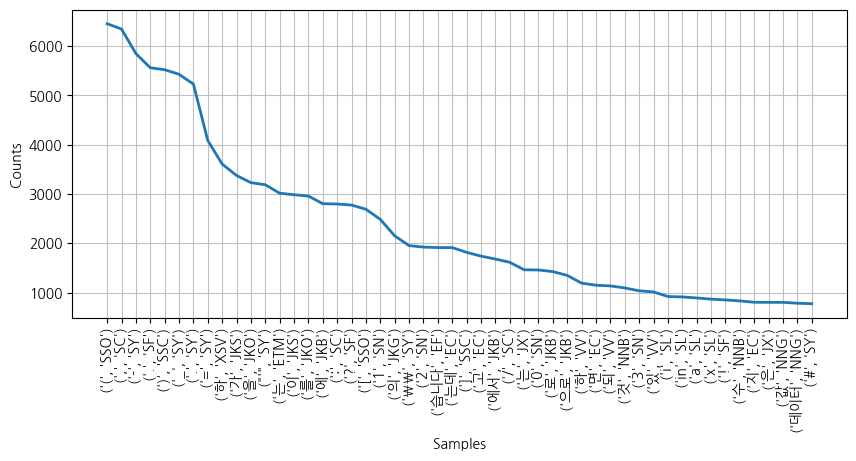

In [40]:
# 각각 Frequency 확인 및 분포 시각화
plt.figure(figsize = (10, 4))
nltk_nouns.plot(50)
plt.show()
plt.figure(figsize = (10, 4))
nltk_morphs.plot(50)
plt.show()
plt.figure(figsize = (10, 4))
nltk_pos.plot(50)
plt.show()

In [41]:
# 명사 추출한 데이터에서 코드, 웹, 이론, 원격, 시스템 등 관심있는 각 단어에 분석해보기
nltk_nouns.concordance('코드', lines = 10)

Displaying 10 of 712 matches:
 업로드 자바 스크립트 동적 폼 개 생성 데 클릭 뭘 수 기본 예제 코드 이유 뭘까요 사용 때 질문 포함 작동 것 질문 제공 파일 폴더 포함
석 아래 가설 검증 방향 접근 방법 비 비 생각 첨부 파일 번 정답 코드 시 패스 출력 문제 요구 건 오답 경우 코드 것 웹 해킹 공부 리 
각 첨부 파일 번 정답 코드 시 패스 출력 문제 요구 건 오답 경우 코드 것 웹 해킹 공부 리 큰따옴표 따옴표 백 슬래시 데이터베이스 전달 
슬라이딩 퍼즐 문제 관련 질문 줄 처 숫자 빈칸 공백 입력 것 이해 코드 작성 초기 퍼즐 상태 이동 상태 저장 이동 상태 이동 횟수 저장 상
리 이동 완료 배열 대응 값 경우 이동한 상태 저장 이동 횟수 다음 코드 작성 예제 입력 정답 것 확인 채점 결과 테스트 케이스 결과 제 부
입력 정답 것 확인 채점 결과 테스트 케이스 결과 제 부분 생각 것 코드 문제 문 감사 강사 참조 자료 아래 강사 거 표 생성 위 자료 코드
코드 문제 문 감사 강사 참조 자료 아래 강사 거 표 생성 위 자료 코드 참조 작성 에러 위 에러 문구 안녕 선형 회귀 로지스틱 회귀 때 사
 저 정의 오류 부분 지 모델 생성 때 방법 설정 선언 걸까요 에러 코드 어디 건지 수 금요일 홈페이지 점검 내용 금일 접속 곳 접속 코딩 
후 부팅 동일 증상 문의 감사 강사 화면 타이핑 강사 채팅 창 입력 코드 북사 오류 값 오류 코드 입니다 문제 번 구군 증가 액 매매 증가 
감사 강사 화면 타이핑 강사 채팅 창 입력 코드 북사 오류 값 오류 코드 입니다 문제 번 구군 증가 액 매매 증가 액 식 차트 에러 데이터 


In [42]:
nltk_nouns.concordance('웹')

Displaying 25 of 49 matches:
관련 포털 운영 이 중심 문제 정의 파일 페이지 제 안사 인프라 구성 웹 서버 솔루션 대 통합 제시 때 배치도 작성 이중화 표현 작성 대로 통
 파일 번 정답 코드 시 패스 출력 문제 요구 건 오답 경우 코드 것 웹 해킹 공부 리 큰따옴표 따옴표 백 슬래시 데이터베이스 전달 위험 걸 
 화면 출력 것 성공 코드 값 변경 코드 걸까요 파일 코드 저장 안녕 웹 페이지 생성 과정 중 페이지 번 이후 오류 문 메모장 제 오리 곤이 
 값 특정 라이브러리 이용 값 건가요 실습 정렬 때 둘 데이터 프레임 웹 화면 진행 서버 실행 오류 서버 실행 건가요 가중치 사용 가중치 것 
 문 안녕 튜 터 조별 과제 중 점 문 고객 요구사항 제 안사 인프라 웹 서버 대 통합 명시 이게 클라우드 대 것 클라우드 웹 서버 질문 배경
제 안사 인프라 웹 서버 대 통합 명시 이게 클라우드 대 것 클라우드 웹 서버 질문 배경 저희 문화재 해설 서비스 클라우드 구축 여기 문화재 
 배경 저희 문화재 해설 서비스 클라우드 구축 여기 문화재 해설 담당 웹 서버 클라우드 구축 것 의문 웹 서버 클라우드 구축 게 클라우드 버킷
클라우드 구축 여기 문화재 해설 담당 웹 서버 클라우드 구축 것 의문 웹 서버 클라우드 구축 게 클라우드 버킷 데이터 백업 활용 감사 매장 위
관관계 시간 전 강우 코드 수 걸까요 안녕 실습 프랙티스 번 진행 중 웹 서버 구축 단계 문 창 복사 명령어 요청 거절 어디 진행 수 다운로드
버 장고 소스 내 곳 모델 연결 부분 수정 개발 장고 수업 이해 입장 웹 개발 쪽 부분 가이드라인 조언 수 가요 교재 페이지 기본 라우팅 테이
행 진행 후 다중 이미지 함수 때 함수 값 리스트 리스트 출력 퍼블릭 웹 서버 설치 후 스턴스 상태 대기 중 끝 나지 중지 삭제 실행 중 연결
 함수 내부 선언 함수 변수 초기 것 해당 함수 내부 것 초기 것 예 웹 프로그래밍 수업 자료 예제 호이 스팅 과정 그림 지 그림 지 위 입력
왼쪽 들여쓰기 위치 

In [43]:
nouns = list(nouns)

In [44]:
# 각각 collocation 확인
from nltk import collocations

measures = collocations.BigramAssocMeasures()

finder = collocations.BigramCollocationFinder.from_words(nouns)
# finder.apply_word_filter()
finder.apply_freq_filter(3)
print(finder.nbest(measures.pmi, 10))

[('스크린', '샷'), ('기', '아이즈'), ('쥬', '피터'), ('경쟁', '우위'), ('목', '금'), ('제론', '테크'), ('디렉', '토리'), ('여름', '가을'), ('창의', '대안'), ('코끼리', '낙타')]


In [45]:
pos = list(pos)

In [46]:
# 각각 collocation 확인
from nltk import collocations

measures = collocations.BigramAssocMeasures()

finder = collocations.BigramCollocationFinder.from_words(pos)
# finder.apply_word_filter()
finder.apply_freq_filter(5)
print(finder.nbest(measures.pmi, 10))

[(('탱크', 'NNG'), ('보이', 'NNG')), (('During', 'SL'), ('handling', 'SL')), (('VirtualBox', 'SL'), ('VMs', 'SL')), (('cp', 'SL'), ('949', 'SN')), (('박', 'NNP'), ('여인', 'NNG')), (('정', 'NNP'), ('류장수', 'NNP')), (('(-', 'SY'), ('215', 'SN')), (('Auto', 'SL'), ('Scaling', 'SL')), (('문화재', 'NNG'), ('해설', 'NNG')), (('direct', 'SL'), ('cause', 'SL'))]


In [47]:
morphs = list(morphs)

In [48]:
# 각각 collocation 확인
from nltk import collocations

measures = collocations.BigramAssocMeasures()

finder = collocations.BigramCollocationFinder.from_words(morphs)
# finder.apply_word_filter()
finder.apply_freq_filter(5)
print(finder.nbest(measures.pmi, 10))

[('디렉', '토리'), ('During', 'handling'), ('VirtualBox', 'VMs'), ('cp', '949'), ('정', '류장수'), ('(-', '215'), ('Auto', 'Scaling'), ('문화재', '해설'), ('direct', 'cause'), ('듀얼', '모니터')]


In [49]:
# 최소 길이 문의 내용에 대해 grammar pasing 해보기(아래 코드 활용)
grammar = """
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
NP_grammar = "NP: {<Adjective>*<Noun>*}"

In [50]:
pos[data.text.str.len().argmin()]

('하', 'XSV')

In [51]:
parser = nltk.RegexpParser(grammar)
chunks = parser.parse(pos[100:110])

In [52]:
!pip install svgling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.3 MB/s eta 0:00:00


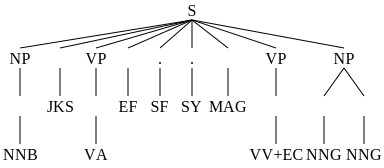

In [53]:
import svgling
chunks

- 데이터 탐색
    - WordCloud 만들기

In [54]:
nouns_list = nltk_nouns.vocab()

In [55]:
data['nouns']

,nouns
0,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]"
1,"[이미지, 개, 업로드, 자바, 스크립트, 동적, 폼, 개, 생성, 데, 클릭, 뭘..."
2,"[사용, 때, 질문, 포함, 작동, 것, 질문, 제공, 파일, 폴더, 포함, 폴더,..."
3,"[오류, 해결]"
4,"[안, 폴더, 안, 이미지, 저장, 걸로, 이해, 실행, 폴더, 이미지, 저장, 질문]"
...,...
3701,"[토큰, 이후, 분리, 벡터, 진행, 데이터, 전, 번, 벡터, 진행, 상관, 머신..."
3702,"[값, 중, 최고점, 건가요, 최근, 파일, 갱신, 최고점, 값, 경우, 변경, 것]"
3703,"[수업, 이유, 인프라, 구조, 이해, 시간, 인프라, 구축, 설계, 구성, 비유,..."
3704,"[값, 변경, 원격, 지원, 가능]"


In [56]:
from nltk import FreqDist

fd_nouns = FreqDist(nouns)
fd_morphs = FreqDist(morphs)
fd_pos = FreqDist(pos)

In [57]:
fd_nouns.most_common(5)

[('것', 1093), ('수', 986), ('값', 801), ('데이터', 783), ('문제', 725)]

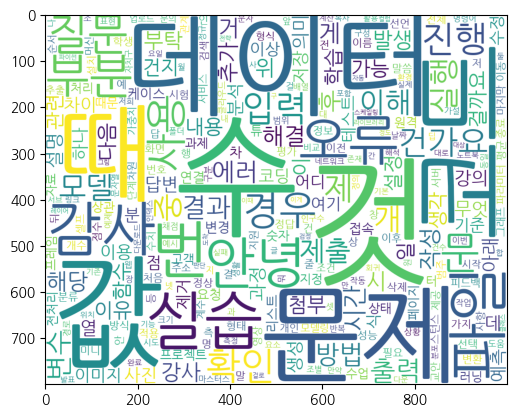

In [58]:
from wordcloud import WordCloud

wc = WordCloud(width = 1000, height = 800, background_color = 'white',
                          relative_scaling = 0.5, max_font_size = 300, max_words = 300,
                          font_path = FONT_PATH)
plt.imshow(wc.generate_from_frequencies(fd_nouns))
plt.show()

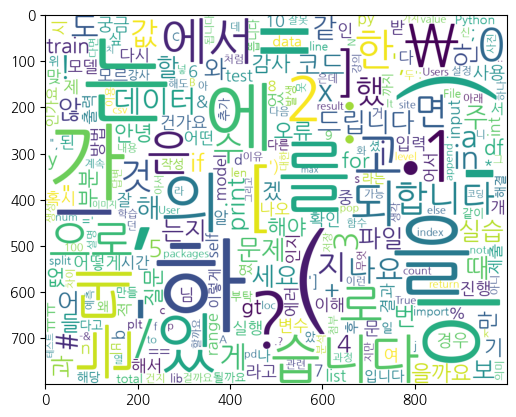

In [59]:
wc = WordCloud(width = 1000, height = 800, background_color = 'white',
                          relative_scaling = 0.5, max_font_size = 300, max_words = 300,
                          font_path = FONT_PATH)
plt.imshow(wc.generate_from_frequencies(fd_morphs))
plt.show()

- 문의 유형에 따른 분석

In [60]:
def text_analysis(df, label=None):
    """
    label에 따라서 분석, label이 None인 경우 전체 분석
    데이터 확인, 데이터 길이 시각화
    명사 추출하여 분석, 워드 클라우드 시각화

    Parameters
    ----------
    df : pandas DataFrame object.
    label : Label for analysis, default=None.
    - If label is None, Entire data are analyzed.

    Returns
    -------
    result : None

    """
    pass
    print('*' * 120)
    if label is None:
        text_question = data['text'].reset_index(drop = True)
        display(data.label.value_counts())
        norm_label = data.label.value_counts(normalize = True)
        display(norm_label)
        norm_label.plot.bar(figsize = (5, 5), color = sns.color_palette('hls', n_colors = len(norm_label)))
        plt.show()
        data.info()
    else:
        text_question = data.loc[data['label'] == label, 'text'].reset_index(drop = True)
        display(f'유형: {label}', text_question.head(10))
    display(text_question.describe(include = 'all'))

    text_length = text_question.apply(len)
    display(pd.DataFrame(text_length).describe().T)
    print('*' * 120)
    print('최대 길이: ', text_question[text_length.argmax()])
    print('최소 길이: ', text_question[text_length.argmin()])

    plt.figure(figsize = (12, 8))
    plt.subplot(2, 1, 1, title = 'max string length : ' + str(max(text_length)))
    sns.histplot(text_length, bins = 50)
    plt.grid()

    plt.subplot(2, 1, 2)
    sns.boxplot(x = text_length)
    plt.grid()
    plt.show()
    print('-' * 120)

    nouns = text_question.apply(lambda t: mecab.nouns(str(t)))
    nouns = nltk.Text(nouns.explode())
    nouns = nltk.Text([w for w in nouns if isinstance(w, str)])
    #word cloud
    cloud = WordCloud(
        max_font_size = 100, max_words = 50,
        background_color = 'white', relative_scaling = .5,
        width = 800, height = 600, font_path = FONT_PATH).generate(" ".join(nouns))
    plt.figure(figsize = (10, 8))
    plt.imshow(cloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

    display(nouns.vocab().most_common(n = 10))

************************************************************************************************************************


'유형: 시스템 운영'

,text
0,한달에 한번 지원금 들어오기로 했는데 국민 내일배움카드로 입금은 언제되나요?
1,안녕하세요 \n\n코딩마스터스 재밌게 하고 있는 에이블러입니다.\n\n코딩마스터스가...
2,"금요일에 홈페이지 점검이 있다는 내용을 들었었는데, 금일 접속해 보니 다른 곳은 다..."
3,운영자 02님 혹시 원격 기다리실까봐 문의글 남깁니다.\n어차피 오전시간 얼마 안 ...
4,안녕하세요 DX7조입니다.\n제출 버튼에 ppt 파일을 먼저 제출하고 나서 발표영상...
5,안녕하세요!\n\n갑자기 셀프 테스트를 보는 도중 창이 다 꺼지고 홈으로 돌아갔는데...
6,AIDU 환경에서 한번 나오면 시험 끝이라는 강사님 말씀을 듣고 질문을 남깁니다.\...
7,최종개별실습 파일제출시에 제가 다른 경로로 저장한 빈파일을 올려서 \n소스코드가 하...
8,채점 했을때는 전부 pass로 뜨는데 제출하면 오답이라고 하는데 제출할 때 다른 케...
9,11월 10일 개인과제 제출 버튼을 누르면 아래와 같은 화면이 뜨면서 과제 제출이 ...


,text
count,561
unique,561
top,한달에 한번 지원금 들어오기로 했는데 국민 내일배움카드로 입금은 언제되나요?
freq,1


,count,mean,std,min,25%,50%,75%,max
text,561.0,89.613191,71.10484,10.0,46.0,71.0,113.0,650.0


************************************************************************************************************************
최대 길이:  안녕하십니까 다름아니라 8월 11일에 치룬 셀프테스트 결과를 확인하고 문의드릴점이 있어 글을 작성하게되었습니다 다름아니라 A-2번 문제는 실습A-2에서 실수값을 갖는 열의 개수를 구하는 문제입니다 저는 해당 문제를 풀기위해 info()함수를 제대로 이용하여 실수형 열의 개수를 구했습니다 저는 앞선 문제에서 mall 데이터에 열을 추가하는 문제를 먼저 푸는 바람에 A-2번 문제를 풀게되었을때 실수형태의 열 개수가 추가되어 기존의 실수형 형태의 열 개수가 2개에서 3개로 바뀌어 제 답안에는 실수형 열 개수가 3개라는 결과를 얻게되었습니다ㅠㅠ.. 이 경우에는 부분점수를 받거나 점수 변동이 가능할까요? 제 실습 파일을 보면 알 수 있듯이 사용해야하는 함수도 제대로 썼지만 앞서 열 추가 문제를 먼저 푸는 바람에 A-2번 문제를 풀때 열추가가된 것 같습니다.. 

추가로 95점 이상 남성을 구하는 문제에 있어 제가 등호표시를 &gt;로만 하여 아쉽게 오답으로 처리되었는데요.. 이 경우도 부분점수를 받을 수 있을까요?? 

그리고 이번 미니프로젝트 개별실습 채점방식은 앞서 오티때 말씀해주신것처럼 0~100점 형태의 점수표기가 아닌 NP/P 로 채점되는것인가요?? 

잘하고싶은 마음에 사소한것까지 하나하나 물어보게되었습니다 항상 성의껏 답변해주셔서 감사합니다!
최소 길이:  제출 오류가 뜹니다


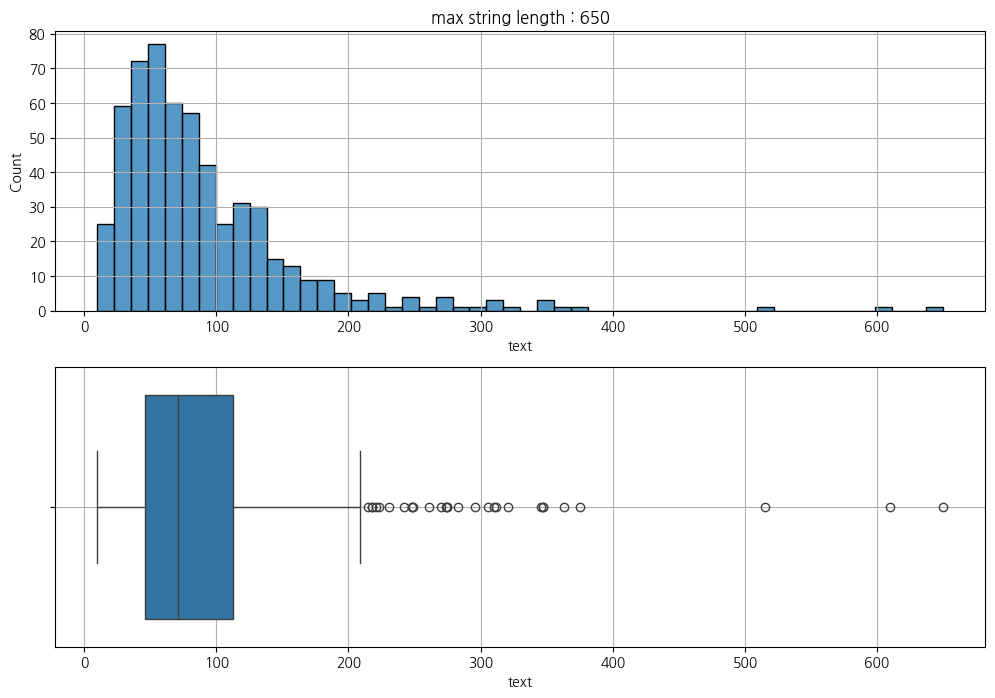

------------------------------------------------------------------------------------------------------------------------


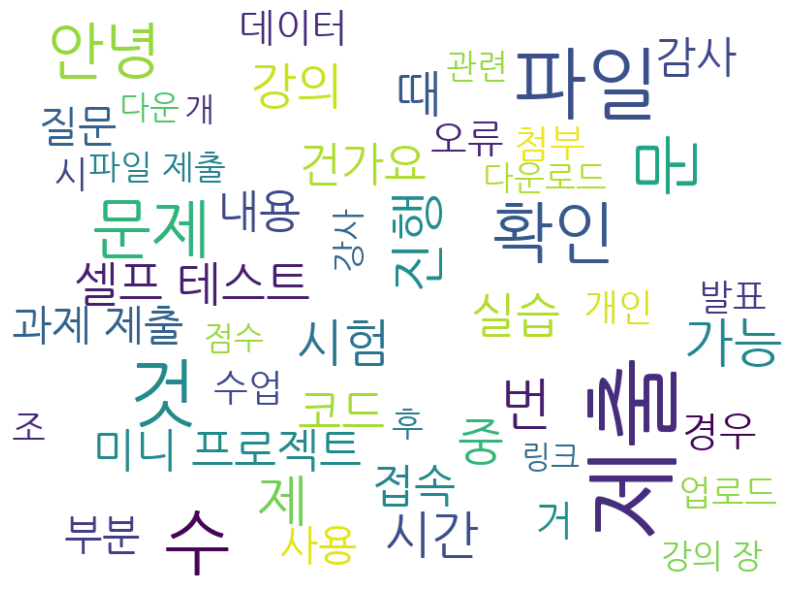

[('제출', 316),
 ('파일', 224),
 ('수', 132),
 ('확인', 125),
 ('것', 124),
 ('안녕', 113),
 ('문제', 112),
 ('문', 103),
 ('강의', 103),
 ('실습', 97)]

************************************************************************************************************************


'유형: 원격'

,text
0,"말씀하신대로 하였으나, 이번에는 이런 오류가 발생합니다.\n\ncannot impo..."
1,어떻게 삭제하는지 모르겠어요 ㅜ 원격지원 부탁드려도 될까요..
2,마지막으로 안내해주신 명령어대로 수행해봤는데 역시 에러메시지가 뜹니다 ㅠㅠ\n혹시 ...
3,https://113366.com?accessCode=107144링크로 접속 후 프...
4,"네트워크 오류 관련 알려주신 내용 확인해 봤는데 안됩니다,,,, 원격 부탁드려도 되..."
5,"튜터님,\n\n말씀해주신 urls.py 부분 해결하였습니다. 감사합니다.\n\n하지..."
6,원격제어를 추가하는 것이 안됩니다
7,1대1 원격조종으로 문제 해결 위해 남겨둔 질문입니다.
8,강사님께서 프로그램 다 종료하고 다시 가이드대로 해보라고 하셨는데도 계속 버츄얼 네...
9,안녕하세요 깃허브 등록이안되서 원격제어 부탁드립니다.


,text
count,100
unique,100
top,"말씀하신대로 하였으나, 이번에는 이런 오류가 발생합니다.\n\ncannot impo..."
freq,1


,count,mean,std,min,25%,50%,75%,max
text,100.0,84.02,86.997037,9.0,39.75,58.0,104.25,683.0


************************************************************************************************************************
최대 길이:  튜터님,

말씀해주신 urls.py 부분 해결하였습니다. 감사합니다.

하지만 아래 코드 실행시 또다른 에러가 발생합니다.
- C:\dev\mini_pro7&gt;python manage.py migrate
- C:\dev\mini_pro7&gt;python manage.py runserver

에러내용은 아래와 같습니다.
- OSError: [WinError 123] 파일 이름, 디렉터리 이름 또는 볼륨 레이블 구문이 잘못 
되었습니다: ''
- ModuleNotFoundError: No module named 'reference.urls'

문제 해결을 위해 https://bladewalker.tistory.com/713와 https://stackoverflow.com/questions/58873810/django-runserver-error-frozen-importlib-bootstrap를 참조하여
-  pip install --upgrade reference
- C:\dev\mini_pro7&gt;python manage.py makemigrations
코드를 실행하였으나 지속적으로 또다른 오류가 발생합니다.

---

다른 팀원분들께 여쭤보니 파이썬을 다시 삭제후 재설치를 권유하던데, 혹시 삭제후 재설치를 해야 할까요?
번거로우시겠지만, 원격으로 가상환경 세팅 도와주시면 정말 감사드리겠습니다.

최소 길이:  원격 부탁드립니다


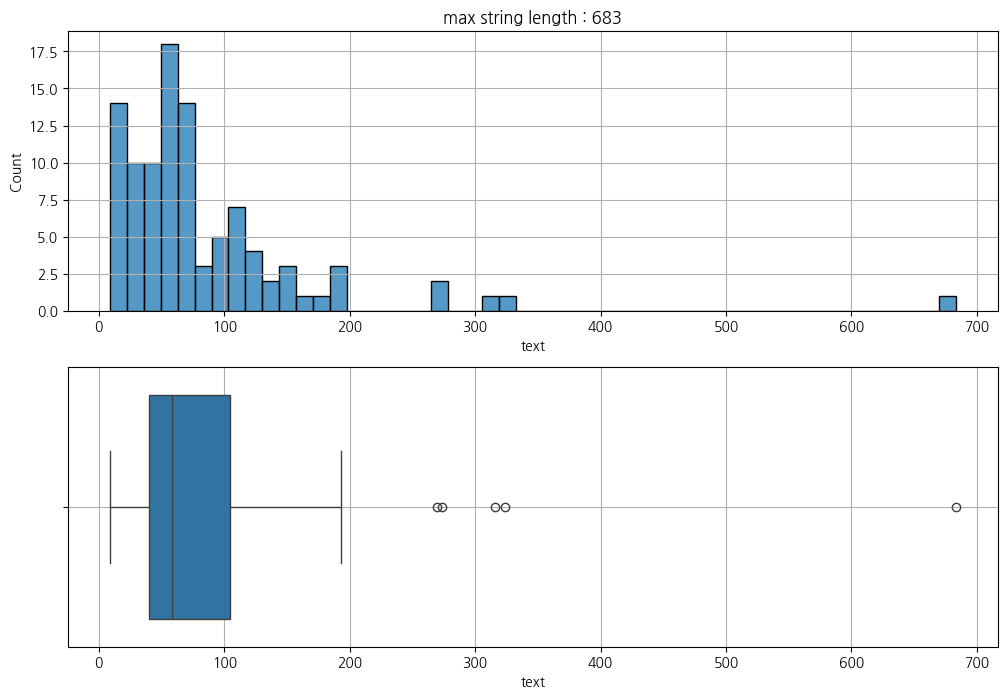

------------------------------------------------------------------------------------------------------------------------


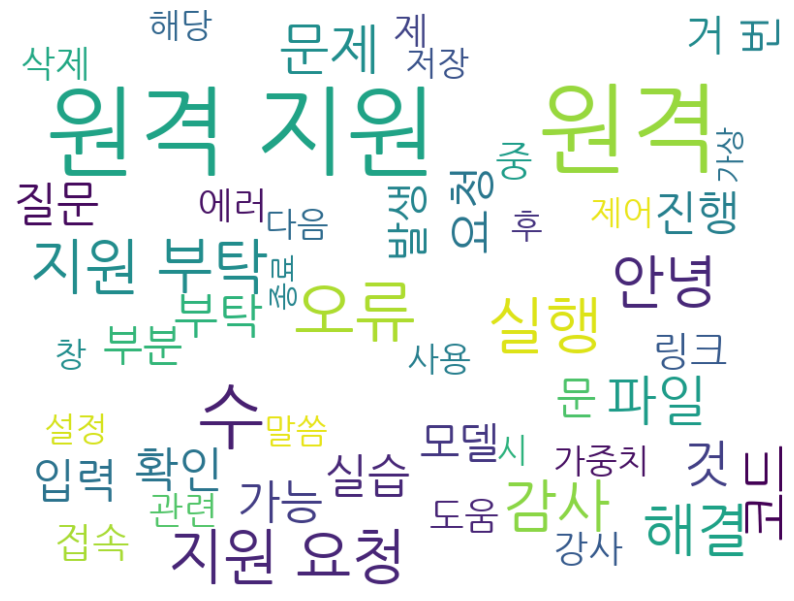

[('원격', 98),
 ('지원', 51),
 ('부탁', 26),
 ('요청', 26),
 ('수', 23),
 ('오류', 19),
 ('실행', 17),
 ('해결', 15),
 ('감사', 15),
 ('안녕', 15)]

************************************************************************************************************************


'유형: 웹'

,text
0,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...
1,PDF파일을 보시면 7페이지에 제안사 인프라는 3Tier로 구성(WEB/WAS/DB...
2,다시 쳐보기도 하면 오타 확인했지만 오타는 없었습니다. 그리고 해당 index파일도...
3,윈도우 프롬프트에서 작업중 cd Downloads 이후 퍼블릭 DNS를 연결하면 e...
4,아니면 혹시 인스턴스가 종료되었는데 삭제하기가 보이지가 않아서 새로운 인스턴스를 만...
5,두번째로 주신 OneDrive에 window10.ova파일이 아직 업로드 되지 않은...
6,google sheet의 제 master IP를 찾아 복사한 뒤 인스턴스 목록에서...
7,라우팅 테이블 설정에서 프라이빗서브넷이 퍼블릭 라우팅 테이블로 설정을 하였습니다.\...
8,강사님이 주신 참조자료 보면서 만들고 있습니다.\nhttps://findwork.d...
9,아까 rows에서 s빼먹어서 넣고 다시 돌려봤을때는 분명 열 저체가 다 나왔었거든요...


,text
count,732
unique,732
top,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...
freq,1


,count,mean,std,min,25%,50%,75%,max
text,732.0,184.84153,448.83214,13.0,60.0,101.0,172.0,5690.0


************************************************************************************************************************
최대 길이:  $ python manage.py createsuperuser

You have 18 unapplied migration(s). Your project may not work properly until you apply the migrations for app(s): admin, auth, contenttypes, sessions.
Run 'python manage.py migrate' to apply them.
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\django\db\backends\utils.py", line 84, in _execute
    return self.cursor.execute(sql, params)
  File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\django\db\backends\mysql\base.py", line 73, in execute
    return self.cursor.execute(query, args)
  File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\MySQLdb\cursors.py", line 206, in execute
    res = self._query(query)
  File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\MySQLdb\cursors.py", l

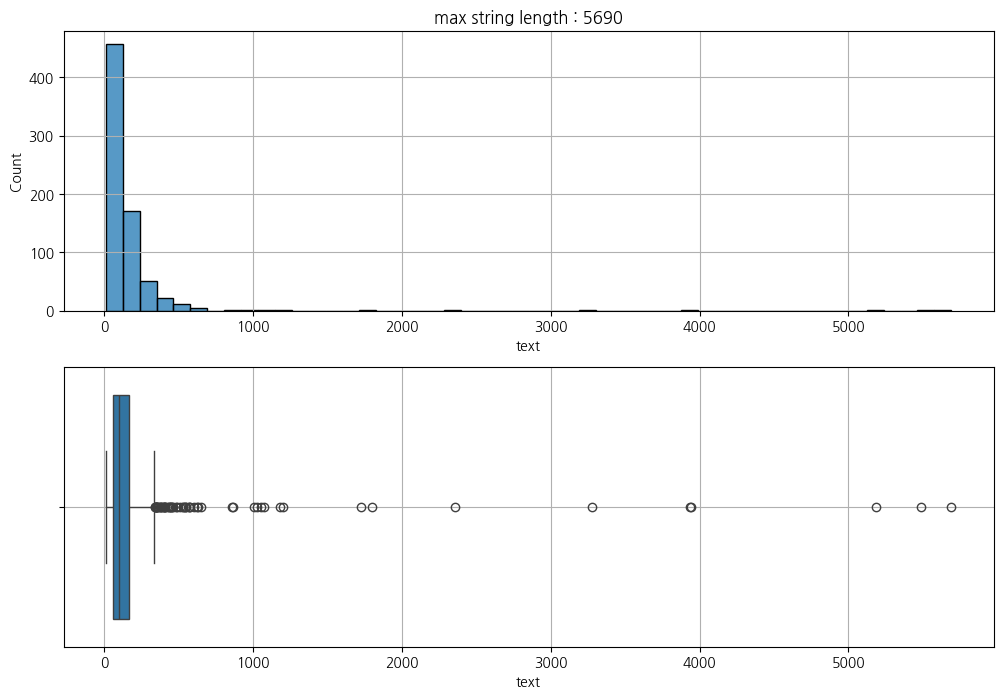

------------------------------------------------------------------------------------------------------------------------


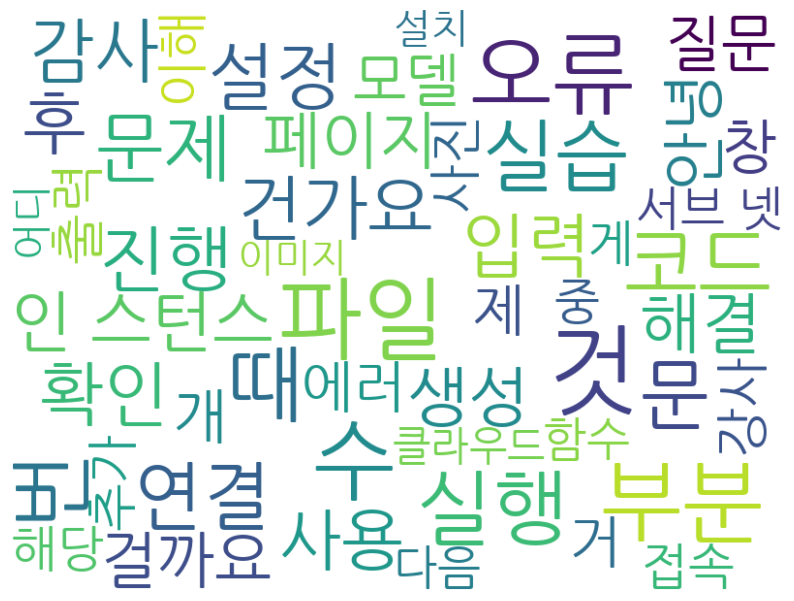

[('실습', 159),
 ('오류', 146),
 ('수', 142),
 ('것', 137),
 ('파일', 123),
 ('실행', 123),
 ('진행', 109),
 ('부분', 108),
 ('때', 99),
 ('안녕', 99)]

************************************************************************************************************************


'유형: 이론'

,text
0,"저는 헬스케어, 그중에서도 정신건강에 대해 관심이 많습니다. 디지털 치료제와 관련한..."
1,범주형 데이터와 숫자형 데이터 설명해주신 내용 잘 읽었습니다. 계속 읽고 적응해나아...
2,"안녕하세요.\n\n실습1 제출합니다.\n피드백 부탁드립니다.\n\n+) 추가로, 저..."
3,아이피 중에 13.13.12.2와 13.13.23.2가 없는데 어떤 것을 연결하는건...
4,"backbone은 기본 골자이고, head는 backbone을 바탕으로 목적에 맞게..."
5,3. IDF가 높다는 것은 적은 수의 문서에서 나타난다는 뜻이므로 그 단어가 그 문...
6,[실습4]\n\n쿠팡의 경우 유통업이지만 오픈마켓으로도 분류할 수가 있는데 제가 작...
7,도메인 관련 논문 검색 후 유의미한 feature 1차로 추려내서 데이터 전처리하는...
8,변수와 타겟간 가설수립을 할 때 변수간 관계를 이용해 변수를 추가해서 사용해도 될까...
9,"이동인구 : 추정 합산값으로 소수점 표출, 개인정보 비식별화를 위해 3명 미만의 경..."


,text
count,728
unique,728
top,"저는 헬스케어, 그중에서도 정신건강에 대해 관심이 많습니다. 디지털 치료제와 관련한..."
freq,1


,count,mean,std,min,25%,50%,75%,max
text,728.0,138.668956,101.730658,13.0,71.0,110.0,178.25,915.0


************************************************************************************************************************
최대 길이:  수업에서 cacoo랑 packet tracer를 배우는 이유가

1. IT 인프라 구조에 대해서 이해해보는 시간
- 비록 직접 인프라를 구축 및 설계는 하지 않을지라도 어떻게 구성되어 있고 어떻게 돌아가는지는 알아보자.
적절한 비유일지는 모르겠으나, 운전을 하는 게 목표라고 할 때, 
우리가 자동차를 직접 설계하고 만들지는 않아도 자동차가 연료를 연소시키면서 엔진에 동력을 전달해서 그 힘으로 움직인다. 라는 식으로 원리와 과정을 아는 것과 같은 맥락...이려나요?

2. (DX과정이므로 DX 컨설턴트 및 관련 직무를 위한 교육이라고 가정할 때) DX 관련 업무에서 실제로 IT 인프라를 구축해야하는 경우가 있으며, 이 때 실제 장비를 가지고 하나씩 연결해보고 시도해보기에는 물리적(시간, 돈, 장소 등)제약이 있으므로 가상으로 해본다.

3. 적절한 비유일지는 모르겠으나...
수학에서 미적분을 배우는 게 최종 목표라고 했을 때, 처음부터 미적분을 학습시킬 수 없으니 그 기초가 되는 수열, 수열의 극한, 함수의 극한 순으로 배우듯이 DX 컨설턴트 과정에서 기초라 할 수 있는 IT 인프라를 학습하는 과정에 있는 것이다.

상기한 3가지 이유인가요?

이전까지 계속 코딩과 데이터 전처리 및 분석으로 달려오다가 갑자기 가상 세계 속에서 무언가를 구성해보기도 하고, 도식화 해보기도 하니 순간 이걸 배우는 목적이 무엇인가? 라고 했을 때 말문이 막혀서 한번 질문 드렸습니다.

훌륭한 커리큘럼을 구성한 교육과정에서 배우는 입장에서 이러한 의문을 가지는 게 터무니 없을 수도 있으나 목적의식과 목표에 대해서 알면 무엇을 좀 더 중점적으로 학습해야 할지 알 수 있을 거 같아서 문의드립니다. ^^:

추가적으로 혹시 실례가 안 된다면 실무에서 cacoo와 

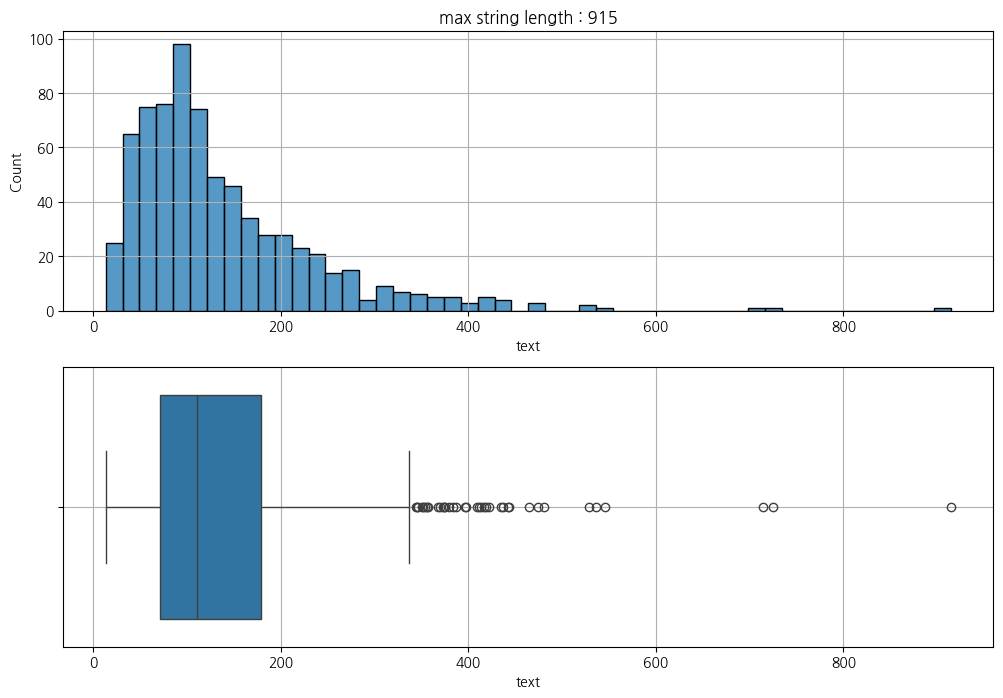

------------------------------------------------------------------------------------------------------------------------


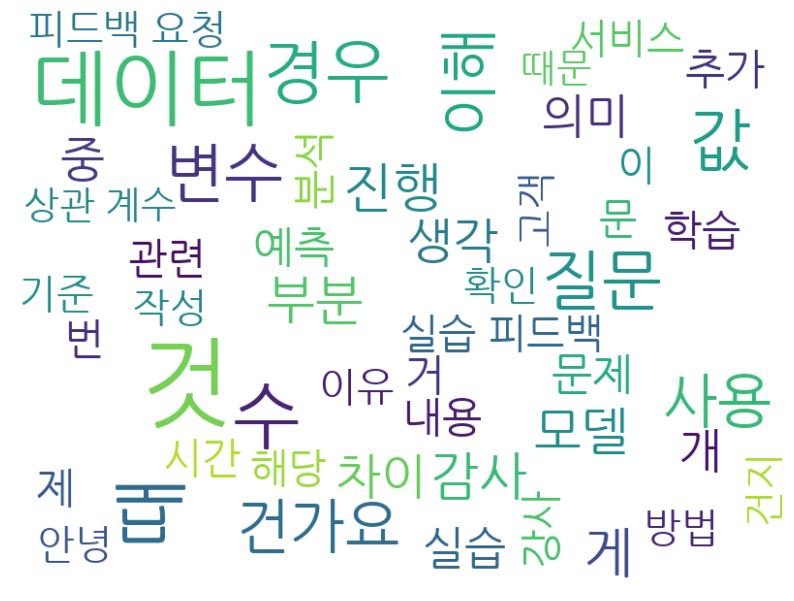

[('것', 375),
 ('데이터', 276),
 ('때', 209),
 ('수', 199),
 ('값', 198),
 ('실습', 172),
 ('경우', 162),
 ('변수', 158),
 ('이해', 151),
 ('질문', 146)]

************************************************************************************************************************


'유형: 코드1'

,text
0,첨부파일에 3375.번에 대해 정답인 코드로 돌렸을 시 다 패스가 출력되었지만 문제...
1,앗...제가 질문을 잘못드려서 혼란이 있으셨을 듯 합니다 죄송합니다...ㅠ\n원질문...
2,제가 All Failed를 말씀드린건.. 실행에는 아무문제가 없기 때문입니다...\...
3,안녕하세요! 3436번. 슬라이딩 퍼즐 문제 관련하여 질문드립니다.\n우선 3줄에 ...
4,"안녕하세요, 답변에 감사드립니다. 3389 커트라인 정하기 추가 문의 드립니다. \..."
5,52 54 55번은 모두 3360번 문제입니다..\n\n추가로 반복문 안에 조건문이...
6,안녕하세요 3417. 오리 농법 예제 입력 1의 예제 출력 1에 대해 질문 드립니다...
7,함수 say_hey를 만들어 보세요.\n횟수를 받는 입력 매개변수 count(숫자)...
8,"w =int(input(""수도사용량:""))\nb= input('회사명:')\ndef..."
9,파이썬을 이번에 처음 배우게 되었습니다. 코딩마스터즈 테스트에서\n\nfrom sy...


,text
count,488
unique,488
top,첨부파일에 3375.번에 대해 정답인 코드로 돌렸을 시 다 패스가 출력되었지만 문제...
freq,1


,count,mean,std,min,25%,50%,75%,max
text,488.0,333.356557,316.485935,12.0,124.0,242.5,414.0,2655.0


************************************************************************************************************************
최대 길이:  import collections
import re
a=list(input()) # 반복시킬 문자열 받기
b= input() # 목적
c=0 # 반복 횟수
y = [] # 반복할 문자열 갯수 
f = str(a[0]+'+'+a[1]+'+'+a[2]+'+') 

z = re.findall(f, b) 
z = list(str(z)) # z는 반복 대상 문자열
for i in z:
    if i in a:
        y.append(i)   # z중 '' ','등 불필요 문자 제거, 
        
if a[0]==a[1]==a[2]: # 반복시킬 문자열이 모두 같을 때
    d1=collections.Counter(a) # a 문자열 갯수
    d2=collections.Counter(y) # y 문자열 갯수
    while True:
        if d2-d1!=collections.Counter(): # a의 모든 문자가 반복대상 문자보다 수가 적을 때
            a=a*2 # a문자열 반복
            c+=1 # 반복횟수 추가
            d1=collections.Counter(a) # 
            continue
        if d2-d1==collections.Counter(): # a의 모든 문자가 반복대상 문자보다 수가 크거나 같을 때
            print(c)
            break                   
        
elif (a[0]!=a[2]) & (a[0] == a[1]): # AAB와 같은 경우
    d1=collections.Counter(a)
    d2=collections.Counter(y)
    while 

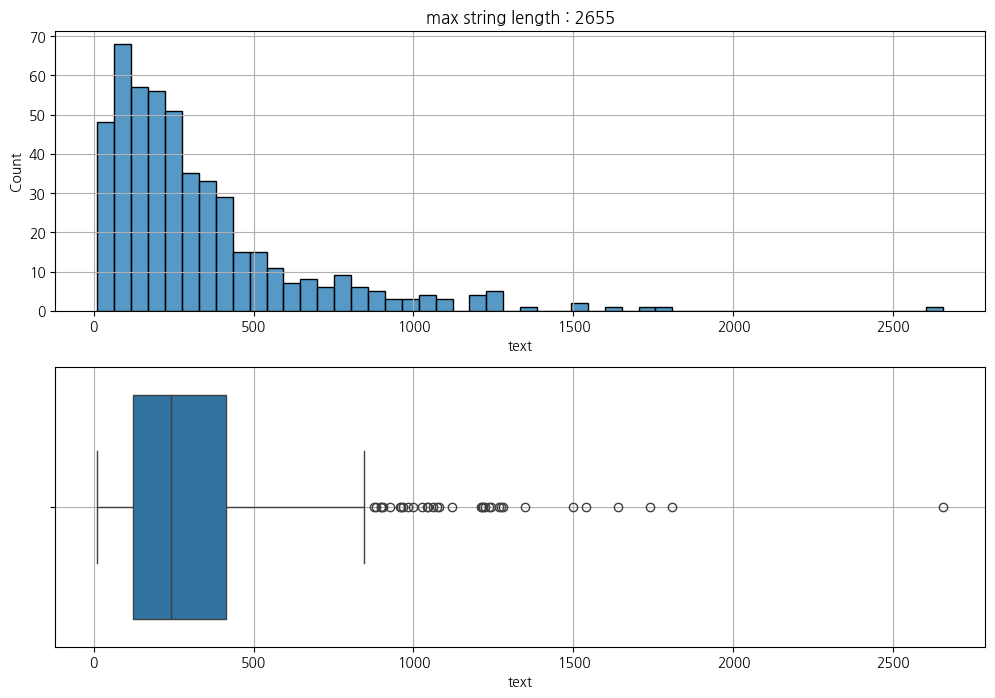

------------------------------------------------------------------------------------------------------------------------


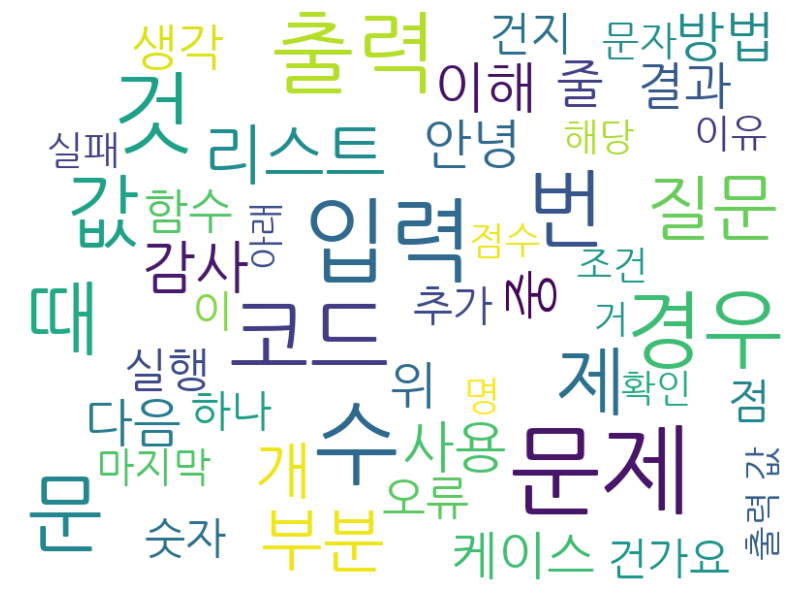

[('문제', 266),
 ('값', 244),
 ('수', 239),
 ('입력', 237),
 ('출력', 216),
 ('코드', 203),
 ('번', 179),
 ('것', 166),
 ('때', 151),
 ('경우', 149)]

************************************************************************************************************************


'유형: 코드2'

,text
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ..."
1,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...
2,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals..."
3,filename = TEST_IMAGE + str(round(frame_sec)) ...
4,만약\n각각 결측치가 하나씩 있는 경우를 제외하고\nOzone 열에도 Solar....
5,"궁금한 사항은 다음과 같습니다.\n1) data에 있는 연속형 변수 A,B가 존재한..."
6,model.predict() 에서 \n'float' object cannot be ...
7,x_train = scaler.fit_transform(x_train) \nx_va...
8,"train_x,train_y= train_test_split(df_total,tes..."
9,모델 학습 시 아래와 같은 error 메세지가 나와서 어떻게 해결해야 할지 문의 드...


,text
count,1097
unique,1097
top,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ..."
freq,1


,count,mean,std,min,25%,50%,75%,max
text,1097.0,261.750228,398.162267,13.0,90.0,158.0,285.0,6012.0


************************************************************************************************************************
최대 길이:  sns.kdeplot(x = td[var])
plt.show()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
 in 
----&gt; 1 sns.kdeplot(x = td[var])
      2 plt.show()

~\anaconda3\lib\site-packages\seaborn\_decorators.py in inner_f(*args, **kwargs)
     44             )
     45         kwargs.update({k: arg for k, arg in zip(sig.parameters, args)})
---&gt; 46         return f(**kwargs)
     47     return inner_f
     48 

~\anaconda3\lib\site-packages\seaborn\distributions.py in kdeplot(x, y, shade, vertical, kernel, bw, gridsize, cut, clip, legend, cumulative, shade_lowest, cbar, cbar_ax, cbar_kws, ax, weights, hue, palette, hue_order, hue_norm, multiple, common_norm, common_grid, levels, thresh, bw_method, bw_adjust, log_scale, color, fill, data, data2, warn_singular, **kwargs

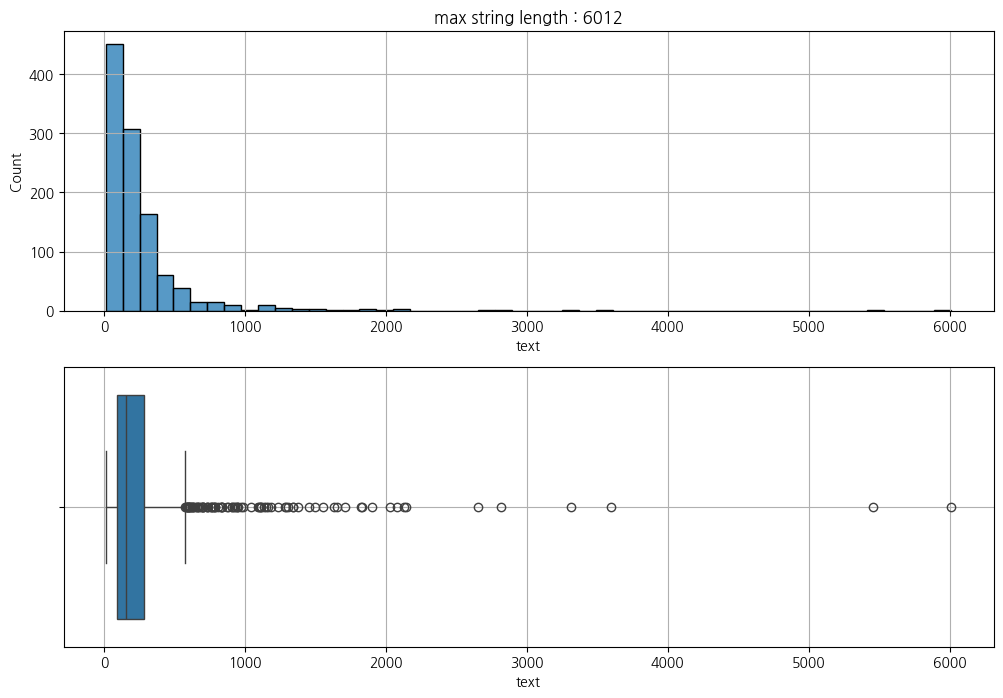

------------------------------------------------------------------------------------------------------------------------


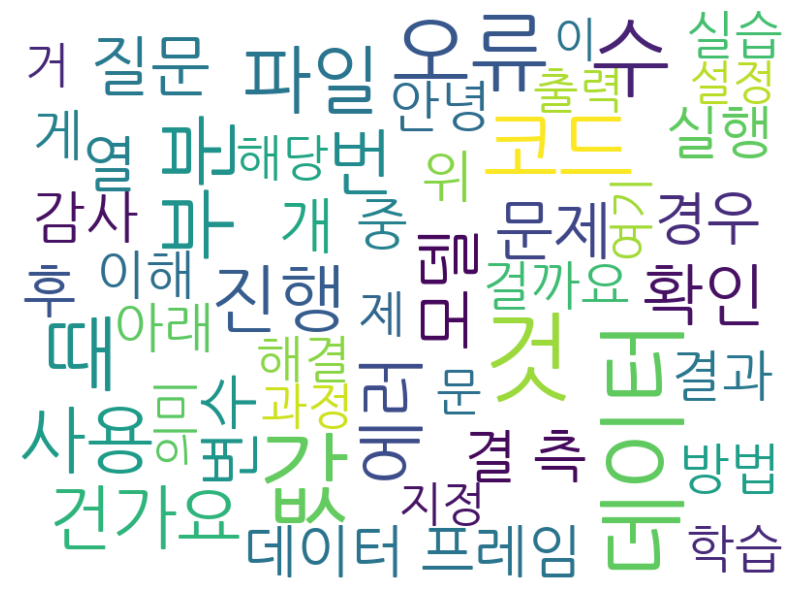

[('데이터', 405),
 ('코드', 336),
 ('값', 303),
 ('것', 280),
 ('오류', 253),
 ('수', 251),
 ('때', 195),
 ('문제', 186),
 ('부분', 173),
 ('에러', 170)]

In [61]:
for label in sorted(data.label.unique()):
    text_analysis(data,label)

In [62]:
train_re = pd.DataFrame(data)

In [64]:
# data에 품사 추가하여 데이터셋 재구성
train_re.to_csv('/content/drive/MyDrive/Type_of_Inquiry_Classification/train_re.csv', index = False)